## Plot the rolling 28-day count of active reviewers on Amazon

In [16]:
# https://nijianmo.github.io/amazon/index.html
# 6.7gb
# May 1996 - Oct 2018
# item,user,rating,timestamp
# e.g., 0449819906,A3U4E9PIZ8OWH1,5.0,1383696000
# timestamp is then unix time in seconds.
review_data = {
 'Amazon Fashion': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/AMAZON_FASHION.csv',
 'All Beauty': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv',
 'Appliances': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Appliances.csv',
 'Arts, Crafts and Sewing': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing.csv',
 'Automotive': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Automotive.csv',
 'Books': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books.csv',
 'CDs and Vinyl': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/CDs_and_Vinyl.csv',
 'Cell Phones and Accessories': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories.csv',
 'Clothing, Shoes and Jewelry': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Clothing_Shoes_and_Jewelry.csv',
 'Digital Music': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music.csv',
 'Electronics': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics.csv',
 'Gift Cards': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Gift_Cards.csv',
 'Grocery and Gourmet Food': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food.csv',
 'Home and Kitchen': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Home_and_Kitchen.csv',
 'Industrial and Scientific': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Industrial_and_Scientific.csv',
 'Kindle Store': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Kindle_Store.csv',
 'Luxury Beauty': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty.csv',
 'Magazine Subscriptions': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Magazine_Subscriptions.csv',
 'Movies and TV': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Movies_and_TV.csv',
 'Musical Instruments': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments.csv',
 'Office Products': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Office_Products.csv',
 'Patio, Lawn and Garden': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Patio_Lawn_and_Garden.csv',
 'Pet Supplies': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Pet_Supplies.csv',
 'Prime Pantry': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Prime_Pantry.csv',
 'Software': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software.csv',
 'Sports and Outdoors': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Sports_and_Outdoors.csv',
 'Tools and Home Improvement': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Tools_and_Home_Improvement.csv',
 'Toys and Games': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Toys_and_Games.csv',
 'Video Games': 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games.csv'
}

In [50]:
import pandas as pd
# even with a 28d sliding window, if we're sliding by a day, it's still quite a few data points
(pd.Timestamp('Oct 2018') - pd.Timestamp('May 1996')) / pd.Timedelta('1d')

8188.0

In [40]:
# store all urls in a variable
from shlex import quote
x = ' '.join(list(map(quote, review_data.values()))[:3])
! echo {x}

http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/AMAZON_FASHION.csv http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Appliances.csv


In [ ]:
! echo 'will cite' | parallel --citation 1> /dev/null 2> /dev/null 

In [48]:
%%bash -s {x}

# How many reviews?
parallel 'curl -sNL {} | wc -l' ::: "$@" \
  | awk '{s+=$1}END{print s}'

1857758


In [49]:
%%bash -s {x}

# How many users?
# do this in addition to show off.
# TODO -- raw merge extension, dsrs --raw inside parallel, dsrs --merge outside
parallel 'curl -sNL {} | cut -d, -f2' ::: "$@" \
  | dsrs

1515676


In [58]:
%%writefile /tmp/date-user-extract.awk
#!/usr/bin/awk

BEGIN {
    FS = "," 
}

1 {
    user = $2;
    epoch_sec = $4;
    # round down to nearest day
    rounded_epoch_sec = strftime("%Y %m %d 00 00 00", epoch_sec);
    rounded_epoch_sec = mktime(rounded_epoch_sec)
    for (i = 0; i < 28; i += 1) {
        dt = strftime("%F", rounded_epoch_sec);
        print dt " " user
        # a day can be more than this many seconds due to leaps but
        # since we only decrement 28 times the undershoot doesn't matter
        rounded_epoch_sec -= 86400
    }
}

Overwriting /tmp/date-user-extract.awk


In [64]:
%%bash

# test date mapper
echo 0449819906,A3U4E9PIZ8OWH1,5.0,1383696000 | awk -f /tmp/date-user-extract.awk | head -3

2013-11-05 A3U4E9PIZ8OWH1
2013-11-04 A3U4E9PIZ8OWH1
2013-11-03 A3U4E9PIZ8OWH1


In [65]:
%%bash -s {x}

# How many 28d users?
# TODO -- slb extension (needs piping) instead of parallel
parallel 'curl -sNL {} | awk -f /tmp/date-user-extract.awk' ::: "$@" \
  | dsrs --key > /tmp/ts

In [74]:
t = pd.read_csv('/tmp/ts', delimiter=' ', names=["date", "cnt"])
t.set_index("date", inplace=True, verify_integrity=True)
t.head()

,cnt
date,
2012-06-01,1594
2007-05-17,274
2017-08-12,26571
2015-03-15,25280
2011-03-07,1013


In [75]:
t.sort_index(inplace=True)

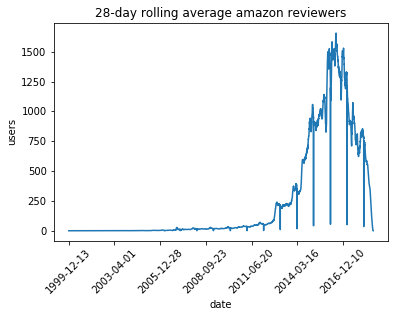

In [81]:
from matplotlib import pyplot as plt
%matplotlib inline
(t/28).plot(rot=45, legend=False)
plt.xlabel("date")
plt.ylabel("users")
plt.title("28-day rolling average amazon reviewers")
plt.show()